# M4.D1: Introduction to molecular dynamics

## Learning Objectives

* Explain what part of the assumptions and equations that we used in module 3 to calculate macroscopic properties are not valid any more for interacting or condensed matter systems.
* Build a script that randomly places particles in a volume that matches a certain density
* Build a script that assigns random velocities to particles according to a thermal distribution
* Given a time-step and a certain number of steps or simulation time, build a script that iteratively solves the equations of motion of a set of particles.

# For non-ideal gases, the partition function is not analytical

We learned that the heat capacity of a monoatomic ideal gas is $\frac{3}{2}RT$, this result was obtained assuming that, as ideal, the atoms do not interact with each other so that the total partition function is just a product of independent particles $Q = \frac{q^N}{N!}$

However, when that is not the case, we are left with having to calculate the macroscopic partition function as a summation of all possible macrostates

$$
Q = \sum_i e^{-\frac{E_i}{k_B T}} \neq \frac{q^N}{N!}
$$

Notice that $E_1, E_2, E_3...$ are not the internal energy levels of one molecule, it is all the possible positions and speeds of particles, in other words, the microstates of the macroscopic system.

We will have to **sample the phase space** that is consider all possible positions and velocities of our particles to calculate our partition function.

Traditionally in molecular simulations there are two main strategies to "sample" the phase space, molecular dynamics and montecarlo. However, [sampling methods](https://en.wikipedia.org/wiki/Sampling_(statistics)) are a vast area of computational physics.

Try to have a picture of the vast number of configurations in which the picture below can arrange. The phase space is enourmous for any realistic model. This where the "art of modeling" needs to be considered.

1. The number of particles in the system has to be large enough that allow us to calculate realistic properties
2. The energy among the particles has to be accurate enough. The energy will have a kinetic component (related to temparature) and a potential energy component.
3. The sampling (number of positions and velocities considered) has to be large enough so that the properties converge. If the sampling involves the equations of motion we will have to calculate the derivative of the potential to obtain the forces.

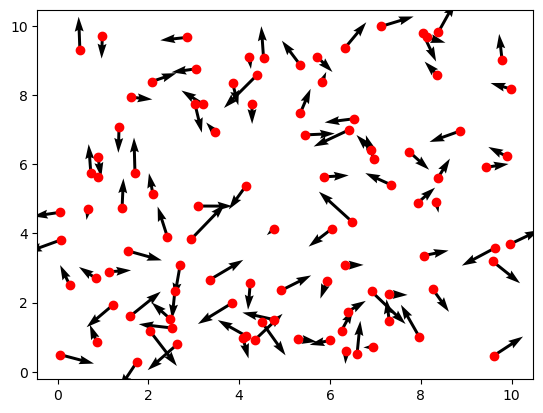

In [2]:
#Source: https://gist.github.com/jhjensen2/71bdb95ca0b12e22fa176c86b46e28b5#file-noninteracting_particle_md-ipynb
import numpy as np
import matplotlib.pyplot as plt
box_width = 10
n_particles = 100

x_coord = []
for i in range(n_particles):
    x_coord.append( np.random.random()*box_width )
#
y_coord = []
for i in range(n_particles):
    y_coord.append( np.random.random()*box_width )

x_vel = [2*(np.random.random()-0.5)*box_width for i in range(n_particles)]
y_vel = [2*(np.random.random()-0.5)*box_width for i in range(n_particles)]
plt.plot(x_coord,y_coord,'ro')
plt.quiver(x_coord,y_coord,x_vel,y_vel);

Or more realistically, we can plot them in 3D

In [3]:
import plotly.express as px
import pandas as pd

z_coord = []
for i in range(n_particles):
    z_coord.append( np.random.random()*box_width )
coords = pd.DataFrame()
coords["x"]=x_coord
coords["y"]=y_coord
coords["z"]=z_coord    
fig = px.scatter_3d(coords, x='x', y='y', z='z')
fig.show()

# First step of moelcular dynamics: Initial position of particles

Let's say we want to simulate liquid water. We need to place water molecules so that it matches with its density, which is 1g/mL. How many molecules of water would you place in a cube with a boxsize=10 angstroms?

$1Å=10^{-10}m$ 

* What volume of your box would contain 100 particles?
* Each student should generate a random box with 100 particles and calculate the average distance among particles?
    * You will have to build a double loop, for 100 particles there will be 99 distances.
    * Remember the cartesian distance between two points \
    $p_1 = (x_1,y_1,z_1)$ and $p_2 = (x_2,y_2,z_2)$\
    $r = \sqrt{ (x_1-x_2)^2 + (y_1-y_2)^2 + (z_1-z_2)^2}$
* Build a histogram showing the distance among molecules

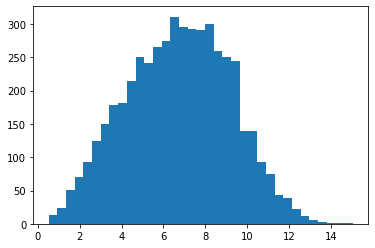

# Second step: Calculate the potential energy

How do particles interact with each other? In previous chemistry semesters you learned about different types of intermolecular forces (Hydrogen bonds, dipole dipole interactions, and London or dispersion forces). One of the earliest potential energy expressions to describe dispersion forces are the Lennar-Jones potentials

Lennard-Jones, J. E. Proc. Royal Soc. Lond. A. 1924, 106 (738), 463–477. 10.1098/rspa.1924.0082.

$$
E_{LJ}(r)= 4\epsilon\left[\left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r} \right)^6 \right]
$$

$\sigma$ is the so-called Van der Waals radius, that is the radius where the potential is zero. The parameter $\epsilon$ is the energy at the well of potential.

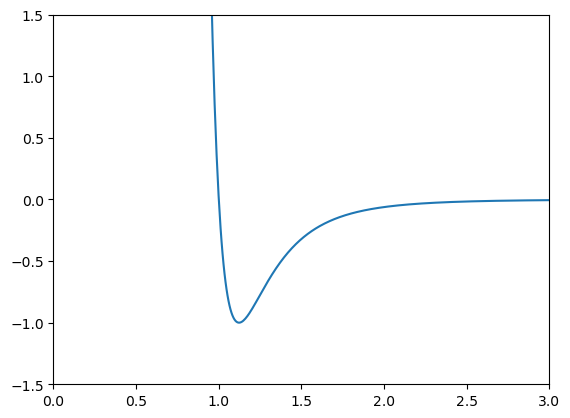

In [3]:
r = np.linspace(0.01,3.0,num=500) # Make a radius vector
epsilon = 1 # Energy minimum
sigma = 1 # Distance to zero crossing point
E_LJ = 4*epsilon*((sigma/r)**12-(sigma/r)**6) # Lennard-Jones potential

plt.xlim([0.0,3.0])
plt.ylim([-1.5,1.5])
plt.plot(r,E_LJ);

**Your turn**

* Plot below a Lennard-Jones potential of a larger particle with a stronger interaction.
* Given the Lennard-Jones potential, calculate the potential energy of the whole system. 
* Build a histogram of the energy of each particle.
* You probably will have obtained some very high energies due to overlapping atoms. You can set a maxmimum energy to a relatively small and positive value, say 1.5 (arbitrary number).

# Third step: Give velocity to particles for thermal distribution

Given that the contribution from translations was $\frac{3}{2}RT$, each direction of space x,y,z contributes with $\frac{1}{2}RT$ which comes exclusively from kinetic energy $\frac{1}{2}mv^2$

$$
\frac{1}{2}RT = \frac{1}{2} m v_x^2
$$

$$
v_x = \sqrt{\frac{RT}{m}}
$$




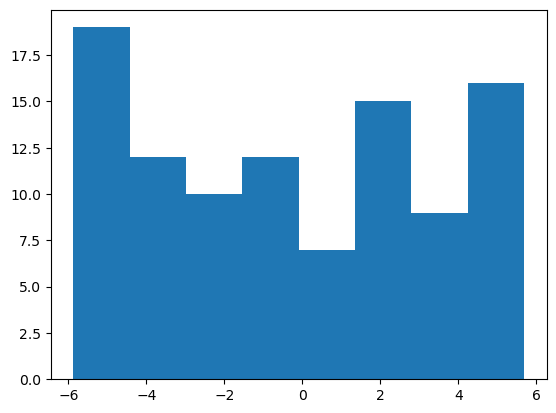

In [4]:
mass_of_water = 18
R = 8.31
T = 300

rand_dist = np.random.rand(n_particles) - 0.5
vels_x = rand_dist * np.sqrt(R* T / (mass_of_water))
vels_y = rand_dist * np.sqrt(R* T / (mass_of_water))
vels_z = rand_dist * np.sqrt(R* T / (mass_of_water))
plt.hist(vels_x, bins='auto')
plt.show();

* Now that each particle has a potential interaction and a velocity, calculate the energy of the system by adding the kinetic and the potential.

# Solve equations of motion step by step: run a simple molecular dynamics

The number of possible configurations of position and velocity in an atomic system is very large. However, not all those configurations will contribute significantly to the partition function as some of them may have high energy.

A way to sample the most *accessible configurations* is using thermal molecular dynamics in which the system evolves accoding to the Newton equations of motion.

$$
x = x_0 + v_0 t + 0.5 a t^2
$$

where the acceleration comes from the second law of Newton $F=ma$ and the force is the derivative of the energy $F=-\frac{dE}{dx}$

$$
a= - \frac{dE}{m dx}
$$

and

$$
v = v_0 + at
$$

0. Decide units and parameters

    0.1 Length: angstrom. This is decided so that your 14.04 angstrom box has 100 particles to match the density of water. Maybe start with fewer particles and a smaller box.
    
    0.2 Mass: atomic mass units. Water 18 amu
    
    0.3 Energy: electron-volts. This means that R gas constant is rather $\frac{k_B}{q_e} = 8.63e-5$
    
    0.4 The units of energy also effect the sigma and epsilon values. Sigma is in angstroms and it can be set to 1 angstrom. Epsilon is in electron-volts can be set to 0.2
    
    0.5 The Time step should be 0.1 angstroms.

1. Initialize your system. Build a function for each task.

    1.1 Randomize xyz coordinates positions. 
    
    1.2 Assign random velocities according to the temperature 300K
    
    $$
    v_x = \sqrt{\frac{RT}{m}}
    $$
    
    1.3 Calculate accelerations based on the positions
    
    $$
    a= - \frac{dE}{m dx}
    $$
   
2. Loop for a number_of_steps. Set a low number of steps to test things.

    2.1 Update positions according to velocities and accelearations
    
    2.2 Get new accelerations
    
    2.3 Update velocities
    
    2.4 Calculate the new position using
    
    $$
    x = x_0 + v_0 t + 0.5 a t^2
    $$
    
    2.5 Calculate kinetic, potential, and total Energy
    
    2.6 Calculate temperature 
    
    2.6 Save positions to a list of lists
    

Run it for few steps and see if it works. If it explodes you probably have some overlapping particles. If that's the case, diminish the time step.

* Analyze/plot how the energies (kinetic, potential and total) change through time
* Analyze how the distances and size of the box is maintained
* Make any corrections necessary.

# Questions

* Explain with your words why we need to sample the phase space of the system and can't use the previous independent particle model.
* Solve the rest of the exercises